In [ ]:
!pip install langchain-tavily
!pip install langchain_groq
!pip install langgraph

In [ ]:
import os
from langchain_tavily import TavilySearch

# Load API key from environment variable
tavily_api_key = os.getenv("TAVILY_API_KEY")

tool = TavilySearch(
    tavily_api_key=tavily_api_key,
    max_results=2
)

result = tool.invoke("What is langgraph")
print(result)


In [15]:
def multiplyTool(a:int,b:int) -> int:
   """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
   return a*b

In [ ]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

# Load variables from .env file
load_dotenv()

# Get Groq API key from environment
groq_api_key = os.getenv("GROQ_API_KEY")

# Initialize ChatGroq
llm = ChatGroq(
    model="llama3-8b-8192",
    api_key=groq_api_key
)


In [ ]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

# Load .env if you are using it locally
load_dotenv()

# Make sure GROQ_API_KEY is set in your environment or .env file
# .env should contain:
# GROQ_API_KEY=gsk_XXXXXX

# Initialize model
llm = init_chat_model("groq:llama-3.3-70b-versatile")

print(llm)


ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7eaafabfe510>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7eaafabfe420>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [18]:
tools=[tool,multiplyTool]

In [19]:
llm_with_tool=llm.bind_tools(tools)

In [20]:
llm_with_tool.invoke("What is latest AI Nesws")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'xbevrdjjv', 'function': {'arguments': '{"query":"latest AI news","time_range":"day","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 1857, 'total_tokens': 1888, 'completion_time': 0.087879244, 'prompt_time': 0.14178367, 'queue_time': 0.197068068, 'total_time': 0.229662914}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--50c88084-e399-4028-8e72-b32e8ab2f075-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'latest AI news', 'time_range': 'day', 'topic': 'news'}, 'id': 'xbevrdjjv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1857, 'output_tokens': 31, 'total_tokens': 1888})

In [24]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [25]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]

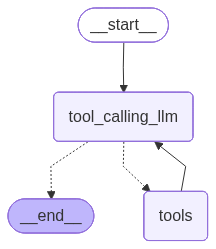

In [26]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [27]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (1e36sbbfj)
 Call ID: 1e36sbbfj
  Args:
    query: recent ai news
    time_range: day
    topic: news
  multiplyTool (s4x1rs82c)
 Call ID: s4x1rs82c
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.govtech.com/education/k-12/baltimore-launches-ai-computer-lab-for-youth-seniors", "title": "Baltimore Launches AI Computer Lab for Youth, Seniors - GovTech", "score": 0.7062922, "published_date": "Tue, 09 Sep 2025 23:44:27 GMT", "content": "## A partnership between Intel, NWN and the city of Baltimore aspires to bridge digital equity gaps by giving communi